# Introduction

👋🏻 Welcome!

In this notebook we will be working with the COVID-19 Radiography Database available at [[1]](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database). It contains 21165 Ches X-Rays (CXRs) belonging to 4 different classes (COVID-19, Lung Opacity, Normal, Viral Pneumonia).

We chose a DenseNet-121 [[2]](https://arxiv.org/abs/1608.06993) architecture, which was tested on ImageNet database [[3]](https://image-net.org), and fine-tuned on the COVID-19 Radiography Database.

We then leverage Gradient Weighted Class Activation Maps (Grad-CAM) [[4]](https://arxiv.org/abs/1610.02391) to show which parts of the image the model is focusing on when making its predictions.

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import utils
import networks

import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from plot_utils import plot_confmat, plot_gradcam
from grad_cam import GradCAM

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from torchinfo import summary

/opt/anaconda3/envs/gradcam/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Visualizing a few images

In [3]:
# Loading the data for visualization
test_set = datasets.ImageFolder(root=utils.dirs['test'], transform=transforms.ToTensor())

# Dataloader
test_dl = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2)

# Load the first batch from the dataloader (size 16)
images, labels = next(iter(test_dl))

class_names = ['covid_19', 'lung_opacity', 'normal', 'pneumonia']
class_samples = {class_name: None for class_name in class_names}

In [4]:
# Get a sample image for each one of the 4 classes
for c in class_samples:
    idx_class = test_set.class_to_idx[c]
    idx_img = torch.where(labels == idx_class)[0][0].item()
    class_samples[c] = images[idx_img]

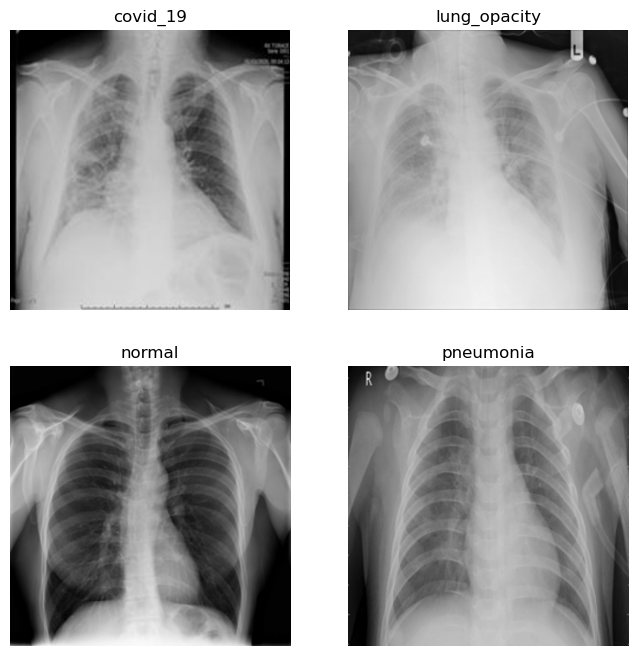

In [5]:
# Plot the samples
fig = plt.figure(figsize=(8, 8))
for i in np.arange(4):
    label = class_names[i]
    img = class_samples[label]
    ax = fig.add_subplot(2, 2, i+1)
    ax.axis('off')
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label)
# fig.savefig('outputs/samples.png')

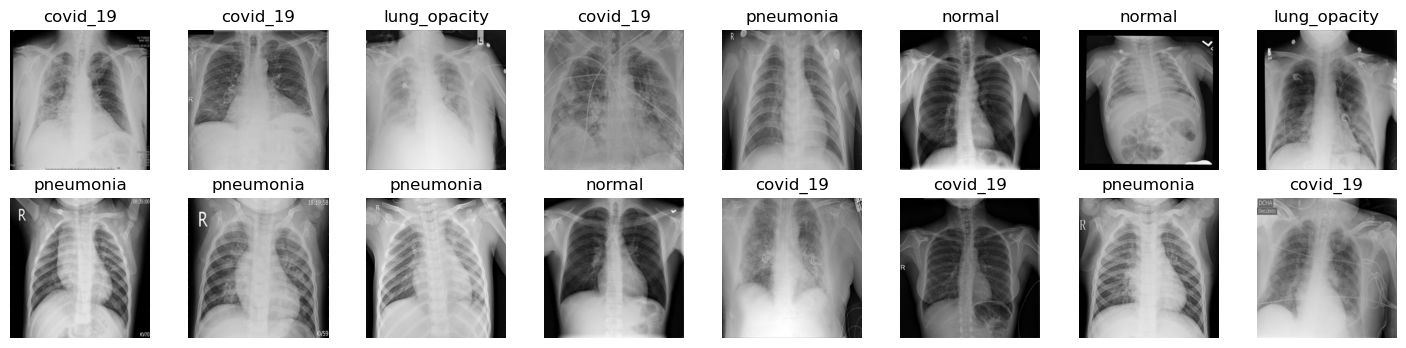

In [6]:
images = images.numpy()

fig = plt.figure(figsize=(18, 4))
for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1)
    ax.axis('off')
    image = np.squeeze(np.transpose(images[i], (1, 2, 0)))
    ax.imshow(image)
    ax.set_title(test_set.classes[labels[i].item()])
    
# fig.savefig('outputs/samples_batch.png')

# Loading data for the models

Now we reload the data by applying traditional data augmentation techniques.

In [7]:
# Loading the data for model
test_set = datasets.ImageFolder(root=utils.dirs['test'], transform=utils.transform['test'])
test_dl = DataLoader(test_set, batch_size=128)

In [8]:
print(f'Number of Images in Test Set: {len(test_set)}')

Number of Images in Test Set: 240


# Loading the model (DenseNet-121)

Loading the pre-tested densenet and freezing all the layers.
This is a huge model with 7 million parameters.

In [9]:
densenet121 = networks.get_densenet121(out_features=4, path='models/lr3e-5_densenet_cuda.pth')

/opt/anaconda3/envs/gradcam/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/gradcam/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
summary(densenet121)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

In [11]:
# Get predictions on the test set
test_preds = utils.get_all_preds(densenet121, test_dl)

In [12]:
test_correct = utils.get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Test Correct:    230	Test Accuracy:  95.83%


Let's look at the predictions in more details by looking at the confusion matrix. We can notice that the model is excellent at predicting COVID-19 cases.

In [13]:
test_confmat = utils.get_confmat(test_set, test_preds)
test_confmat

array([[59,  1,  0,  0],
       [ 0, 55,  5,  0],
       [ 0,  3, 57,  0],
       [ 0,  0,  1, 59]])

<Figure size 1600x600 with 0 Axes>

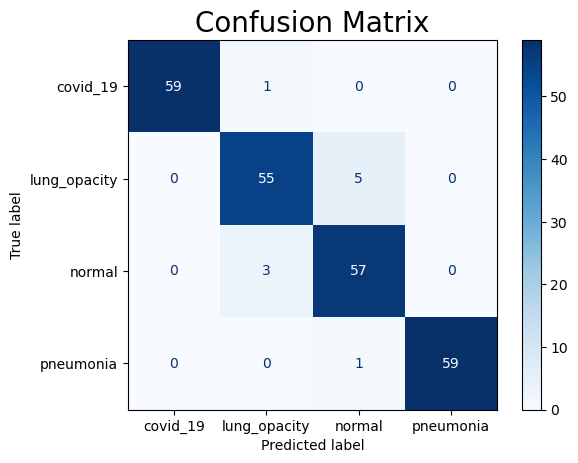

In [14]:
plot_confmat(test_confmat, test_set.classes, f'{type(densenet121).__name__.lower()}')

# GradCAM

/opt/anaconda3/envs/gradcam/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


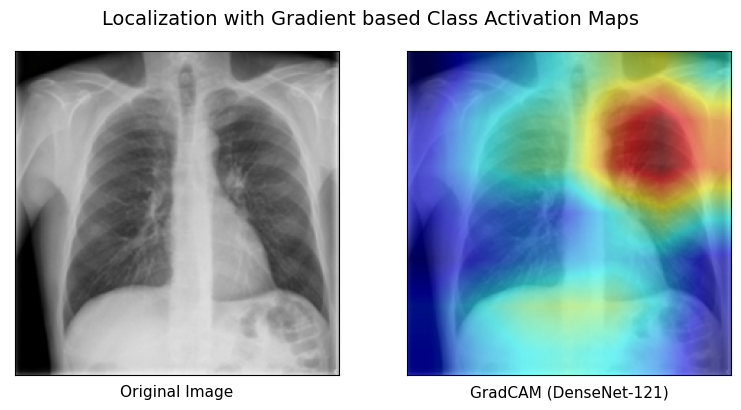

In [15]:
idx_image = 29
image, label = test_set[idx_image]
#Add the batch dimension
image = image.unsqueeze(dim=0).to(device)
#Compute the gradients
cam_obj = GradCAM(model=densenet121, target_layer=densenet121.features[-1])
_, dense_cam = cam_obj(image, label)
filename = 'grad_cam_' + str(idx_image)
plot_gradcam(image, dense_cam, filename)

In [ ]:
idx_image = 33
image, label = test_set[idx_image]
#Add the batch dimension
image = image.unsqueeze(dim=0).to(device)
#Compute the gradients
cam_obj = GradCAM(model=densenet121, target_layer=densenet121.features[-1])
_, dense_cam = cam_obj(image, label)
filename = 'grad_cam_' + str(idx_image)
plot_gradcam(image, dense_cam, filename)

/opt/anaconda3/envs/gradcam/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


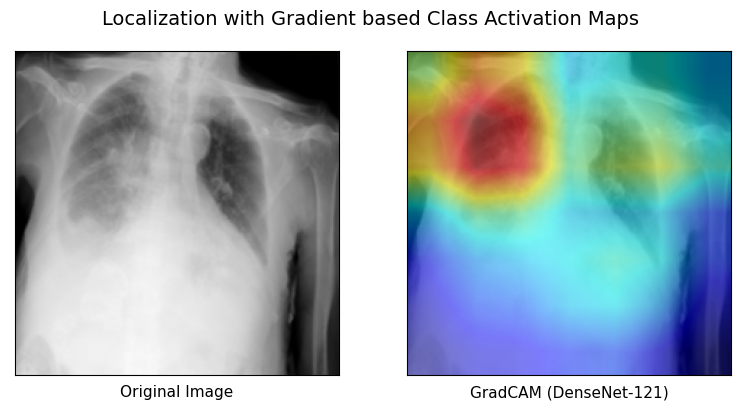

In [22]:
idx_image = 42
image, label = test_set[idx_image]
#Add the batch dimension
image = image.unsqueeze(dim=0).to(device)
#Compute the gradients
cam_obj = GradCAM(model=densenet121, target_layer=densenet121.features[-1])
_, dense_cam = cam_obj(image, label)
filename = 'grad_cam_' + str(idx_image)
plot_gradcam(image, dense_cam, filename)